In [1]:
import os
#Specify whether to use CHEESEHEAD or synthtic data 
os.environ['config'] = 'CHEESEHEAD'
# os.environ['config'] = 'synthetic'

from setup import * #Import setup module
from chad_funcs import *

startdate = dt.datetime(2019, 6, 20)
enddate = dt.datetime(2019, 10, 13, 23, 30)

dtindex = readdata('dtindex', startdate, enddate)
g = 9.81 #Remove after reimporting setup env

In [2]:
# pd.read_csv(tc.loc['PFb']['org_path']).columns

In [3]:
#Func to convert RH to H2O concentration 
#This currently gives water vapor density, might be better to calc as a mixing ratio
#I think this is only valid under the assumption of non divergence/convergence
def H2O_calc(TA, RH):
    
    #Convert T from Celcius to Kelvin
    TA_K = TA + CtoK

    es = 611.2*np.exp(17.67*(TA)/(TA + 243.5)) #Saturation vapor pressure [Pa] - Petty eqn 7.19 (pg 183)
    e = es*RH/100 #Vapor pressure [Pa]
    H2O = e/TA_K/R*mm_w #Water vapor concentration [g/m^3]
    return H2O

In [ ]:
def calc_MO_len(df, PA):
    H_surf = df['H']
    LE_surf = df['LE']

    r = df['H2O_1_3_1']/mm*mm_w/1000 #[g/g] mass mixing ratio of water vapor in dry air (1000 needed to convert mmol to mol)
    theta = df['TA_1_3_1']+273.15 #potential temperatre
    theta_v = theta*(1+0.61*r) #virtual potential temperature

    rho = PA*1000/(R*theta) #Moist Air density [kg moist air/m^3]
    rho_d = rho/(r + 1) #Dry air density [kg dry air/m^3]

    moist_flux = df['LE']/(rho_d*L) #w'r'_bar [m/s * g_watervapor/g_dryair]

    q = r/(1+r) #specific humidity [g_watervapor/g_moistair]
    Cp = cp*(1+0.84*q)
    kin_Hflux = H_surf/(rho*Cp)
    buoy_flux = kin_Hflux*(1+0.61*r)+0.61*theta*moist_flux
    MO = -df['USTAR_1_3_1']**3*theta_v/(k*g*buoy_flux)
    
    return MO

In [5]:
#Set up dataframes to hold needed data
TA = make_multi_df([trac_levlist, towlist], ['lev', 'tow'], dtindex) #Temp
RH = make_multi_df([trac_levlist, towlist], ['lev', 'tow'], dtindex) #Relative humidity (to be converted to H2O mixing ratio)
hrz_wind = make_multi_df([['WS_top', 'WD', 'Ustar'], towlist], ['wind_var', 'tow'], dtindex) #Horizontal wind variable
PA_top = pd.DataFrame(columns = towlist, index = dtindex) #Pressure at highest level (need to get at 30 m for PFA
MO = pd.DataFrame(columns = towlist, index = dtindex) #MO length (for stability analysis)

#Energy budget terms
E_vars = ['Rnet', 'G', 'H_turb', 'LE_turb', 'SG', 'SH', 'SLE'] #energy budget components
E_budget = make_multi_df([E_vars, towlist], ['var', 'tow'], dtindex)



for tow in tc.index:
    towdat = tc.loc[tow] #Tower data
    filepath = towdat.org_path #Eventually use gap-filled data for top level
    df = pd.read_csv(filepath)
    df = df.map(lambda x: np.nan if x == -9999 else x)
    
    #Add datetime index
    dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
    df.set_index(dt_ts, inplace = True)
    
    
    if tow == 'PFA': #Come back and get 30m data here later      
        
        #Linear interpolate PFA data to 15 min and then use just min 15 and 45 timestamps
        PFA_interp = df.resample('15min').mean().interpolate()
        PFA_interp = PFA_interp[(PFA_interp.index.minute == 15) | (PFA_interp.index.minute == 45)]

        #Shift timestamps by 15 min to line up with other data 
        Corrected_TS_start = PFA_interp.index - dt.timedelta(minutes = 15)
        PFA_interp.set_index(Corrected_TS_start, inplace = True)
        
        #Cut to fit dates for the rest of the Cheesehead sites
        PFA_interp = PFA_interp[startdate: enddate]

        #Add PFA 30 m data to dfs
        TA[(30, tow)] = PFA_interp.TA_F_1_3_1 
        RH[(30, tow)] = PFA_interp.RH_1_3_1
        hrz_wind[('WS_top', tow)] = PFA_interp.WS_1_3_1
        hrz_wind[('WD', tow)] = PFA_interp.WD_1_3_1
        hrz_wind[('Ustar', tow)] = PFA_interp.USTAR_1_3_1
        
        #No energy budget components for PFA (not in dataset)
       
    
    else:
        
        #Cut df to desired dates
        df = df[startdate:enddate]
            
        #Add wind and pres data to dfs
        hrz_wind[('WS_top', tow)] = df.WS_1_1_1
        hrz_wind[('WD', tow)] = df.WD_1_1_1
        hrz_wind[('Ustar', tow)] = df.USTAR_1_1_1
        PA_top[tow] = df.PA_1_1_1
        MO[tow] = df.MO_LENGTH_1_1_1
        
        
        #Energy budget components
        E_budget['Rnet', tow] = df.NETRAD_1_1_1
        E_budget['G', tow] = df.G_1_1_1
        E_budget['H_turb', tow] = df.H_1_1_1
        E_budget['LE_turb', tow] = df.LE_1_1_1
        E_budget['SG', tow] = df.SG_1_1_1
        E_budget['SH', tow] = df.SH_1_1_1
        E_budget['SLE', tow] = df.SLE_1_1_1

        
        
        #Towers with only one level
        if towdat.z2 == towdat.z3 == 0:
            TA[(2, tow)] = df.TA_1_1_1
            RH[(2, tow)] = df.RH_1_1_1
            
            
        #Towers with two levels
        elif towdat.z3 == 0:
            TA[(2, tow)] = df.TA_1_2_1
            TA[(10, tow)] = df.TA_1_1_1
            
            RH[(2, tow)] = df.RH_1_2_1
            RH[(10, tow)] = df.RH_1_1_1
            
        #Towers with three levels    
        else:
            TA[(30, tow)] = df.TA_1_1_1
            TA[(10, tow)] = df.TA_1_2_1
            TA[(2, tow)] = df.TA_1_3_1
            
            RH[(30, tow)] = df.RH_1_1_1
            RH[(10, tow)] = df.RH_1_2_1
            RH[(2, tow)] = df.RH_1_3_1
            
            # for PFe interpolate to get 12m (mes taken at 
            if tow == 'PFe':
                TA[(10, tow)] = df.TA_1_3_1 + (df.TA_1_2_1 - df.TA_1_3_1)/(towdat.z2 - towdat.z3)*(mmh - towdat.z3)
                RH[(10, tow)] = df.RH_1_3_1 + (df.RH_1_2_1 - df.RH_1_3_1)/(towdat.z2 - towdat.z3)*(mmh - towdat.z3)
                           
            #For PFl, extrapolate 33m TA from 10 and 25m TA
            if tow == 'PFl':
                TA[(30, tow)]= df.TA_1_2_1 + (df.TA_1_1_1 - df.TA_1_2_1)/(towdat.z1 - towdat.z2)*(mth - towdat.z2)
                RH[(30, tow)]= df.RH_1_2_1 + (df.RH_1_1_1 - df.RH_1_2_1)/(towdat.z1 - towdat.z2)*(mth - towdat.z2)
                
            #For PFt, extrapolate 33m TA from 10 and 25m TA
            if tow == 'PFt':
                TA[(30, tow)]= df.TA_1_2_1 + (df.TA_1_1_1 - df.TA_1_2_1)/(towdat.z1 - towdat.z2)*(mth - towdat.z2)
                RH[(30, tow)]= df.RH_1_2_1 + (df.RH_1_1_1 - df.RH_1_2_1)/(towdat.z1 - towdat.z2)*(mth - towdat.z2)
            

#After all the other data is read in, calc PA and MO length for PFA
PA_top['PFA'] = PFA_interp.PA_1_1_1 #Only have pressure at top of tower, take average pressure at other towers
MO['PFA'] = calc_MO_len(PFA_interp, PA_top['PFA']) #No MO length in PFA data, calculate instead       
             
#Convert RH to H2O concentration
H2O = H2O_calc(TA, RH)




In [6]:
#Save TA, H2O, wind, P, and energy data in pickles
TA.to_pickle(input_filepath + 'Cons_input_data/TA.pickle') #Consolidated input data
H2O.to_pickle(input_filepath + 'Cons_input_data/H2O.pickle')
hrz_wind.to_pickle(input_filepath + 'Cons_input_data/hrz_wind.pickle') #formerly wind_dat
PA_top.to_pickle(input_filepath + 'Cons_input_data/PA_top.pickle')
MO.to_pickle(input_filepath + 'Cons_input_data/MO_length.pickle')
E_budget.to_pickle(input_filepath + 'Cons_input_data/E_budget.pickle')

# Raw w read

In [7]:
startdate = dt.datetime(2019, 6, 20, 0)
enddate = dt.datetime(2019, 10, 14, 23, 30)
dtindex_cut = readdata('dtindex', startdate, enddate)
w_geo = readdata('w_son', startdate, enddate)

In [8]:
tow1 = 'PFe'
tow2 = 'PFg'

In [9]:
filepath = 'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/map/data/csv/flux_' + tc.loc[tow1]['wind_var'][-3:] + '.csv'
w_raw1 = pd.read_csv(filepath, header = 68, skip_blank_lines = False)
w_raw1['dtindex'] = dtindex_cut - dt.timedelta(hours = 6)
w_raw1.set_index('dtindex', inplace = True)
w_raw1 = w_raw1.map(lambda x: np.nan if x == -9999 else x)
w_raw1 = w_raw1.map(lambda x: np.nan if x < -10 else x)
w_raw1 = w_raw1.map(lambda x: np.nan if x > 10 else x)

filepath = 'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/map/data/csv/flux_' + tc.loc[tow2]['wind_var'][-3:] + '.csv'
w_raw2 = pd.read_csv(filepath, header = 68, skip_blank_lines = False)
w_raw2['dtindex'] = dtindex_cut - dt.timedelta(hours = 6)
w_raw2.set_index('dtindex', inplace = True)
w_raw2 = w_raw2.map(lambda x: np.nan if x == -9999 else x)
w_raw2 = w_raw2.map(lambda x: np.nan if x < -10 else x)
w_raw2 = w_raw2.map(lambda x: np.nan if x > 10 else x)

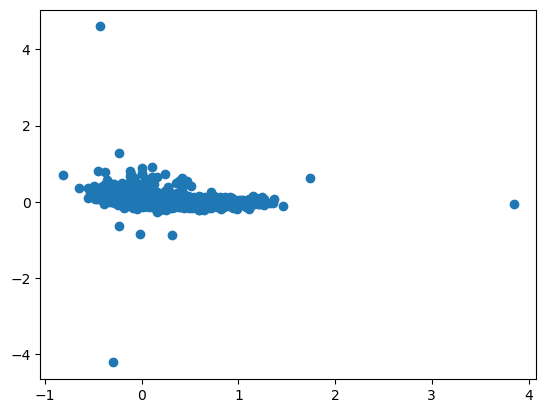

In [10]:
start_cut = dt.datetime(2019, 6, 21)
end_cut = dt.datetime(2019,10, 13)
plt.scatter(w_raw1.w.loc[start_cut: end_cut], w_raw2.w.loc[start_cut: end_cut])
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

## Atm params

In [14]:
zeta = pd.DataFrame(index = dtindex, columns = towlist)
for tow in towlist:
    zeta[tow] = tc.loc[tow]['z_son']/MO[tow]
zeta.to_pickle('../Inputs/zeta.pickle')

MO.to_pickle('../Inputs/MO_length.pickle')

In [12]:
# m = 9
# d = 20
# start_cut = dt.datetime(2019, m, d)
# end_cut = dt.datetime(2019, m, d+5)
# plt.plot(w_raw.w.loc[start_cut: end_cut])
# plt.plot(w_geo['PFe'].loc[start_cut: end_cut])
# plt.xticks(rotation = 45);

# Code Graveyard

NameError: name 'w_cont_cut' is not defined

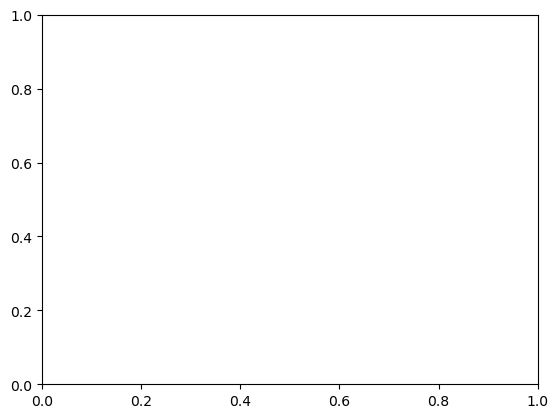

In [13]:
tow = 'PFc'
fig, ax1 = plt.subplots()
plt.plot(w_cont_cut[tow], label = 'continuity');
plt.plot(w_son_cut[tow], label = 'sonic');
# ax2 = ax1.twinx()
# ax2.plot(WD_cut[tow], label = 'wind dir', color = 'k')
fig.legend()
plt.title(tow)
plt.ylabel('w_cont, w_son')
# plt.ylabel('w [m/s]')
plt.xticks(rotation = 45);


In [ ]:
#Code for shifting sonic data from UTC to CST
#Now included in fast_data_read so not needed anymore
# w_son = readdata('vert_wind_sonic')
# index_CDT = w_son.index - dt.timedelta(hours = 6)
# w_son.set_index(index_CDT, inplace = True)
# w_son.to_pickle(input_filepath + 'w_son.pickle')

In [ ]:
# #These should be the same as in Advection_calcs notebook, not needed here anymore
# def WS_top_calc(tower, d_rat = 0.65):
#     k = 0.4 #
    
#     #Measurement height (z1 for all towers except PFA)
#     if tower == 'PFA':
#         h_tow = tc.z3.loc[tower]
#     else:
#         h_tow = tc.z1.loc[tower]
        
#     h_veg = tc.veg_h.loc[tower] #Vegetation height
#     WS_calc = (Ustar[tower]/k)*np.log((h_tow - d_rat*h_veg)/0.1*h_veg)
#     return WS_calc
    
# def prof_calcs(tower, step = 0.1):
#     towdat = tc.loc[tower] #Tower data
    
#     #Step is step size to be used for integration
#     k = 0.4 #Von Karmann constant
#     h_veg = tc.veg_h.loc[tower] #vegetation height
#     h_tow = tc.z1.loc[tower] #tower height
#     z_range = np.arange(0, h_tow + step, step)
#     z_m = 0.1*h_veg #momentum friction parameter
    
#     d = 0.65*h_veg #zero plane displacement
    
#     # d_mean = h_tow - z_m*np.exp(k*WS_top[tower]/Ustar[tower])#zero plane displacement, mean of val calculated for all timestamps
    
    
#     WS_prof = pd.DataFrame() #windspeed profile
    
#     T_grad_NS, T_grad_EW = pd.DataFrame(), pd.DataFrame()
#     H2O_grad_NS, H2O_grad_EW = pd.DataFrame(), pd.DataFrame()
    
#     for z in z_range[::-1]:
#         if z == h_tow:
#             WS_prof[z] = WS_top[tower]
#         elif z >= h_veg:
#             pass
#             # WS_prof[z] = Ustar[tower]/k*np.log((z-d)/z_m)
#         else:
#             pass
            
        
#         if towdat.z3 == 0:
#             pass
#         else:
#             #should maybe make this more flexible for different tower heights
#             T_grad_slope_NS_up = (TA_30_NS[tower] - TA_10_NS[tower])/20 #Slope of temp gradient from 10 to 30 m, NS
#             T_grad_slope_EW_up = (TA_30_EW[tower] - TA_10_EW[tower])/20 #Slope of temp gradient from 10 to 30 m, EW
#             T_grad_slope_NS_low = (TA_10_NS[tower] - TA_2_NS[tower])/8 #Slope of temp gradient from 2 to 10 m, NS
#             T_grad_slope_EW_low = (TA_10_EW[tower] - TA_2_EW[tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
#             H2O_grad_slope_NS_up = (H2O_30_NS[tower] - H2O_10_NS[tower])/20 #Slope of temp gradient from 10 to 30 m, NS
#             H2O_grad_slope_EW_up = (H2O_30_EW[tower] - H2O_10_EW[tower])/20 #Slope of temp gradient from 10 to 30 m, EW
#             H2O_grad_slope_NS_low = (H2O_10_NS[tower] - H2O_2_NS[tower])/8 #Slope of temp gradient from 2 to 10 m, NS
#             H2O_grad_slope_EW_low = (H2O_10_EW[tower] - H2O_2_EW[tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
#             if z >= towdat.z2:
#                 T_grad_NS[z] = TA_10_NS[tower] + T_grad_slope_NS_up*(z-towdat.z2)
#                 T_grad_EW[z] = TA_10_EW[tower] + T_grad_slope_EW_up*(z-towdat.z2)
                
#                 H2O_grad_NS[z] = H2O_10_NS[tower] + H2O_grad_slope_NS_up*(z-towdat.z2)
#                 H2O_grad_EW[z] = H2O_10_EW[tower] + H2O_grad_slope_EW_up*(z-towdat.z2)
#             else:
#                 T_grad_NS[z] = TA_10_NS[tower] - T_grad_slope_NS_low*(towdat.z2 - z)
#                 T_grad_EW[z] = TA_10_EW[tower] - T_grad_slope_EW_low*(towdat.z2 - z)
                
#                 H2O_grad_NS[z] = TA_10_NS[tower] - H2O_grad_slope_NS_low*(towdat.z2 - z)
#                 H2O_grad_EW[z] = TA_10_EW[tower] - H2O_grad_slope_EW_low*(towdat.z2 - z)

                

            
#     return WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW

    
    

In [ ]:
#Top only

# #H and LE advection calcs

# def hrz_ad_calc(tower):

#     #Read in data
#     df = pd.read_csv(tc.org_path.loc[tower])
#     df = df.applymap(lambda x: np.nan if x == -9999 else x)

#     #Add datetime index
#     dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
#     df.set_index(dt_ts, inplace = True)

    
#     PA_Pa = df.PA_1_1_1*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
#     rho = mm*PA_Pa/df_TA_K.T/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
#     z = np.asarray(tc.z)[:, None] #Height of each tower


#     #H advection
#     H_SN = rho*z*cp*SN_wind*(T_i_S - T_i_N)/2000 #Advection of sensible heat by southerly wind [W/m^2]
#     H_WE = rho*z*cp*WE_wind*(T_i_W - T_i_E)/2000 #Advection of sensible heat by westerly wind [W/m^2]
#     H_ad = H_SN + H_WE #Total advection

#     #LE advection
#     LE_SN = z*L*SN_wind*(H2O_i_S - H2O_i_N)/2000 #Advection of latend heat by southerly wind [W/m^2]
#     LE_WE = z*L*WE_wind*(H2O_i_W - H2O_i_E)/2000 #Advection of latent hear by westerly wind [W/m^2]

#     LE_ad = (LE_SN + LE_WE)*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


#     hrz_ad = (H_ad + LE_ad).T
#     #Deal with water vapor later
#     # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

In [ ]:
# #H and LE advection calcs

# def hrz_ad_calc(tower, step = 0.1):

#     WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW = prof_calcs(tower, step)
    
#     TA_K = TA_30[tower] + CtoK
    
#     PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
#     rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
#     z = step #np.asarray(tc.loc[tower].z1) #Height of each tower

#     SN_wind = WS_prof*np.sin(WD[tower]*np.pi/180)
#     WE_wind = WS_prof*np.cos(WD[tower]*np.pi/180)
    
#     #H advection
#     H_SN = T_grad_NS.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by southerly wind [W/m^2]
#     H_WE = T_grad_EW.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by westerly wind [W/m^2]
#     H_ad = H_SN + H_WE #Total advection

#     #LE advection
#     LE_SN = H2O_grad_NS.mul(-z*L*SN_wind/2000, axis = 0)#Advection of latend heat by southerly wind [W/m^2]
#     LE_WE = H2O_grad_EW.mul(-z*L*WE_wind/2000, axis = 0)#Advection of latent hear by westerly wind [W/m^2]
#     LE_ad = (LE_SN + LE_WE)#*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


#     # hrz_ad = (H_ad + LE_ad)
#     H_ad_tot = H_ad.sum(axis = 1)
#     LE_ad_tot = LE_ad.sum(axis = 1)
    
#     return H_ad_tot, LE_ad_tot
#     #Deal with water vapor later
#     # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

In [ ]:
# #Code for plotting T profiles
# # plt.plot(df_mon.TA_1_1_1)

# for tower in tc.index:
#     if tower == 'PFA':
#         pass
    
#     else:
#         print(tower)
#         towdat = tc.loc[tower] #Tower data
#         filepath = towdat.org_path
#         df = pd.read_csv(filepath)
#         df = df.applymap(lambda x: np.nan if x == -9999 else x)

#         #Add datetime index
#         dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
#         df.set_index(dt_ts, inplace = True)
        
#         #Add TA_1_2_1 and TA_1_3_1 for shorter towers
#         # if towdat.z2 == 0:
#         #     df['TA_1_2_1'] = np.nan
#         if towdat.z3 == 0:
#             # df['TA_1_3_1'] = np.nan
#             pass
        
#         else:

#             df_mon = df.groupby([df.index.month, df.index.time]).mean()

#             fig, axs = plt.subplots(12, 4, figsize = (10, 30))
#             for mon in range(6, 11):
#                 # plt.plot(df_mon.TA_1_1_1[mon].values)
#                 i=0
#                 for hour in df_mon.TIMESTAMP_START[mon].index:
#                     ax = axs[i//4, i%4]
#                     i= i+1
                    
#                     TA_top = df_mon.TA_1_1_1[mon][hour] - df_mon.TA_1_2_1[mon][hour]
#                     TA_bottom = df_mon.TA_1_3_1[mon][hour] - df_mon.TA_1_2_1[mon][hour]

#                     # ax.plot([df_mon.TA_1_1_1[mon][hour], df_mon.TA_1_2_1[mon][hour],df_mon.TA_1_3_1[mon][hour]], [towdat.z1, towdat.z2, towdat.z3])
#                     ax.plot([TA_top, 0, TA_bottom], [towdat.z1, towdat.z2, towdat.z3])
#                     ax.set_yticks([towdat.z3, towdat.z2, towdat.z1])
#                     ax.set_title(hour)
#                     ax.set_xlim([-3, 3])

#                 fig.suptitle(tower)
#                 plt.tight_layout()
#                 plt.savefig(str('./Outputs/diff_Profiles/' + tower + '_TA_diff_profiles'))
# #Want to plot profile for each hour x = temperature, y = height
# #Could make 
# # for timme in df_day.index:
# #     profile = [



In [ ]:
'''
Taken from end of Interpfun
This bit of code was to add back in towers with nan values that were removed above. Not needed since 
it is still possible to interpolate to the points N, S, E, and W of those towers without data from the 
towers themselve. However, maybe a good idea to remove those points since interpolation might not be as 
acurate without having data from a nearby point...something to consider
'''

# nan_inds = np.where(nanmask == False)[0] - np.arange(0 ,len(np.where(nanmask == False)[0]))

# dat_N.loc[dat_N.index ==i] = np.insert(dat_N_nn, nan_inds, np.nan)
# dat_S.loc[dat_S.index ==i] = np.insert(dat_S_nn, nan_inds, np.nan)
# dat_E.loc[dat_E.index ==i] = np.insert(dat_E_nn, nan_inds, np.nan)
# dat_W.loc[dat_W.index ==i] = np.insert(dat_W_nn, nan_inds, np.nan)

In [ ]:
# df_test = pd.read_csv('http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/Ameriflux/US-PFb_HH_201906010000_201911010000.csv')

In [ ]:
#Former data consolidation, concats dataframes to get multiindex in rows rather than columns
#Retired as of 5/28/2024

# # #Collect data at 2, 10, and 30m for each tower

# #Fix tower height values #fixthis
                                 
# # #Get dates to use as index from PFb data
# # filepath_i = tc.org_path['PFb'] #i for index because I am just using this to set the index
# # df_i

# #Create empty dataframes for 2, 10, and 30 m
# # TA_2, TA_10, TA_30 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
# # RH_2, RH_10, RH_30 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
# # WS_top, WD, Ustar = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
# # PA_top = pd.DataFrame()






# for tower in tc.index:
#     #print(tower)
#     towdat = tc.loc[tower] #Tower data
#     filepath = towdat.org_path #Eventually use gap-filled data for top level
#     df = pd.read_csv(filepath)
#     df = df.map(lambda x: np.nan if x == -9999 else x)
    
    
#     if tower == 'PFA': #Come back and get 30m data here later
#         TA_2[tower], TA_10[tower] = np.nan, np.nan
#         RH_2[tower], RH_10[tower] = np.nan, np.nan
#         # WS_top[tower], WD[tower], Ustar[tower] = np.nan, np.nan, np.nan
#         # PA_top = np.nan
        
        
#         #Read in PFA data
#         #This is hourly data -> need halfhourly to match up with other towers
#         PFA = pd.read_csv(filepath)

#         PFA = PFA.map(lambda x: np.nan if x == -9999 else x)
        
        
#         #Add datetime index
#         dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
#         PFA.set_index(dt_ts, inplace = True)


#         #Linear interpolate PFA data to 15 min and then use just min 15 and 45 timestamps
#         PFA_interp = PFA.resample('15min').mean().interpolate()
#         PFA_interp = PFA_interp[(PFA_interp.index.minute == 15) | (PFA_interp.index.minute == 45)]


#         #Cut to fit dates for the rest of the Cheesehead sites
#         startdate = dt.datetime(2019, 6, 1)
#         enddate = dt.datetime(2019, 11, 1)
#         PFA_interp = PFA_interp[startdate: enddate]

#         #Shift timestamps by 15 min to line up with other data 
#         Corrected_TS_start = PFA_interp.index - dt.timedelta(minutes = 15)
#         PFA_interp.set_index(Corrected_TS_start, inplace = True)

#         #Add PFA 30 m data to dfs
#         TA_30['PFA'] = PFA_interp.TA_F_1_3_1 
#         RH_30['PFA'] = PFA_interp.RH_1_3_1
#         WS_top['PFA'] = PFA_interp.WS_1_3_1
#         WD['PFA'] = PFA_interp.WD_1_3_1
#         Ustar['PFA'] = PFA_interp.USTAR_1_3_1
#         PA_top['PFA'] = PFA_interp.PA_1_1_1 #Figure out a way to fill in later, only have pressure at top of tower, maybe use average across other towers

        
    
#     else:
#         #Add datetime index
#         dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
#         df.set_index(dt_ts, inplace = True)
        
        
#         #Add wind data to dfs
#         WS_top[tower] = df.WS_1_1_1
#         WD[tower] = df.WD_1_1_1
#         Ustar[tower] = df.USTAR_1_1_1
#         PA_top[tower] = df.PA_1_1_1
        
#         #Towers with only one level
#         if towdat.z2 == towdat.z3 == 0:
#             TA_10[tower],  TA_30[tower] = np.nan, np.nan
#             TA_2[tower] = df.TA_1_1_1
            
#             RH_10[tower],  RH_30[tower] = np.nan, np.nan
#             RH_2[tower] = df.RH_1_1_1
            
            
#         #Towers with two levels
#         elif towdat.z3 == 0:
#             TA_30[tower] = np.nan
#             TA_2[tower] = df.TA_1_2_1
#             TA_10[tower] = df.TA_1_1_1
            
#             RH_30[tower] = np.nan
#             RH_2[tower] = df.RH_1_2_1
#             RH_10[tower] = df.RH_1_1_1
            
#         #Towers with three levels    
#         else:
#             TA_30[tower] = df.TA_1_1_1
#             TA_10[tower] = df.TA_1_2_1
#             TA_2[tower] = df.TA_1_3_1
            
#             RH_30[tower] = df.RH_1_1_1
#             RH_10[tower] = df.RH_1_2_1
#             RH_2[tower] = df.RH_1_3_1
            
#             #For PFl, extrapolate 30m TA from 10 and 25m TA
#             if tower == 'PFl':
#                 TA_30[tower] = df.TA_1_1_1 + (df.TA_1_1_1 - df.TA_1_2_1)/3 #/3 from 5/(25-10)
#                 RH_30[tower] = df.RH_1_1_1 + (df.RH_1_1_1 - df.RH_1_2_1)/3 #/3 from 5/(25-10)

                
                
# #Convert RH to H2O concentration
# H2O_2 = H2O_calc(TA_2, RH_2)
# H2O_10 = H2O_calc(TA_10, RH_10)
# H2O_30 = H2O_calc(TA_30, RH_30)



# #Combine TA, H2O, and wind data into one dataframe (per var)
# #at some point check mesurement levels, might be 3m for one tower--how to handle?
# TA_all = pd.concat([TA_2, TA_10, TA_30], keys = [2, 10, 30])
# H2O_all = pd.concat([H2O_2, H2O_10, H2O_30], keys = [2, 10, 30])
# wind_dat = pd.concat([WS_top, WD, Ustar], keys = ['WS_top', 'WD', 'Ustar'])


# # #Save TA, H2O, wind, P data in pickles
# # TA_all.to_pickle('./Outputs/TA_orig_all.pickle')
# # H2O_all.to_pickle('./Outputs/H2O_orig_all.pickle')
# # hrx_wind.to_pickle('./Outputs/hrx_wind.pickle') #formerly wind_dat
# # PA_top.to_pickle('./Outputs/PA_top.pickle')



# # #Add in PFA data after converting RH to H2O (because only H2O given in PFA dataset) #fixthis

# # #Import data
# # filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
# # PFA = pd.read_csv(filepath)

# # PFA = PFA.map(lambda x: np.nan if x == -9999 else x)

